# By Andrew Marasco on 12/06/2025

![display relevant image here](path/url/to/image)
- Banner/header image

# Title
- Relevant to Data and Business Context

## Overview
- BLUF (Bottom Line Up Front)
- One paragraph summary of final model performance and business implications
- Frame your 'story'

## Business Understanding

1. Begin by thoroughly analyzing the business context of FinTech Innovations' loan approval process. Write a short summary that:
- Describes the current manual process and its limitations
- Identifies key stakeholders and their needs
- Explains the implications of different types of model errors
- Justifies your choice between classification and regression approaches

2. Define your modeling goals and success criteria:
- Select appropriate evaluation metrics based on business impact
- You must use at least two different metrics
- Consider creating custom metric
- Establish baseline performance targets
- Document your reasoning for each choice


### Business Context
# FinTech Innovations partners with banks to modernize their loan-approval workflow. Today, decisions are made mostly by loan officers via manual review, which is slow, inconsistent, and vulnerable to human bias. The company now has historical data on ~20,000 past loan applications, including applicant characteristics, whether the loan was approved, and if the customer later defaulted.
# From the business team:
# Cost of denying a creditworthy applicant (missed good loan): about $8,000 in lost profit per missed loan.
# Cost of approving a bad loan that later defaults: about $50,000 per defaulted loan.
# So both types of error matter, but approving high-risk applicants who default is much more expensive than being overly conservative and missing some good customers. At the same time, the bank must remain competitive and avoid systematically excluding solid applicants.
# Because of regulation and fairness concerns, the model must be transparent and explainable, and performance needs to be evaluated in terms of business impact, not just raw accuracy.

### Modeling Goals & Success Criteria
# Because the cost of approving a bad loan (~$50k) is much higher than denying a good loan (~$8k), the model should prioritize catching high-risk applicants even if that means occasionally rejecting some good ones.
# I’ll use two main evaluation metrics:
# Recall for the “default/high-risk” class (primary metric)
# Interpretation: “Of all applicants who would default, what fraction did we correctly flag as high-risk?”
# Business link: Higher recall reduces the number of bad loans that slip through and cause $50k losses.
# Precision for the “default/high-risk” class or F1/F2 score (secondary metric)
# Precision: “Of all applicants flagged as high-risk, how many actually default?”
# This controls how many good applicants we unnecessarily punish.
# Optionally: use F2-score to weight recall more heavily than precision (reflecting the 50k vs 8k cost ratio).
# Additional monitoring metrics:
# ROC-AUC / PR-AUC for overall ranking quality.
# Confusion matrix at chosen probability threshold to quantify counts of false approvals vs false denials.
# Calibration / probability distributions, if time permits.
# Success criteria (example, adapt to your actual results):
# Achieve at least X% recall on the default class (e.g., ≥ 80%) while keeping precision above Y% (e.g., ≥ 40–50%), relative to a baseline model (e.g., simple logistic regression or rule-based cutoff).
# Demonstrate that the selected threshold meaningfully reduces expected dollar loss compared to the current manual process or a naive baseline.

## Data Understanding
3. Conduct comprehensive exploratory data analysis:
- Describe basic data characteristics
- Examine distributions of all features and target variables
- Investigate relationships between features
- Create visualizations to help aid in EDA
- Document potential data quality issues and their implications

4. Develop feature understanding:
- Categorize features by type (numerical, categorical, ordinal)
- Identify features requiring special preprocessing
- Document missing value patterns and their potential meanings
- Note potential feature engineering opportunities


In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-process and Pipeline tools
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Model Seleciton and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


Dataset Shape: (20000, 35)

Missing Values:
CreditScore             0
LoanAmount              0
DebtToIncomeRatio       0
MonthlyIncome           0
EmploymentStatus        0
EducationLevel        901
MaritalStatus        1331
LoanPurpose             0
dtype: int64

Data Types:
CreditScore            int64
LoanAmount             int64
DebtToIncomeRatio    float64
MonthlyIncome        float64
EmploymentStatus      object
EducationLevel        object
MaritalStatus         object
LoanPurpose           object
dtype: object


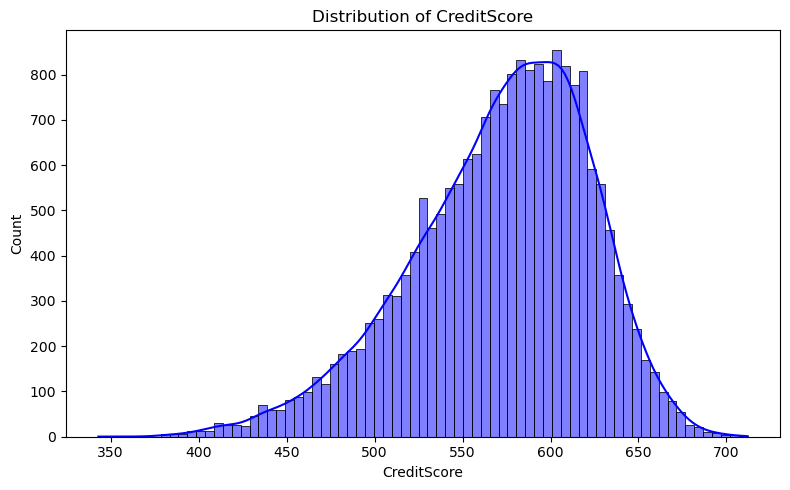

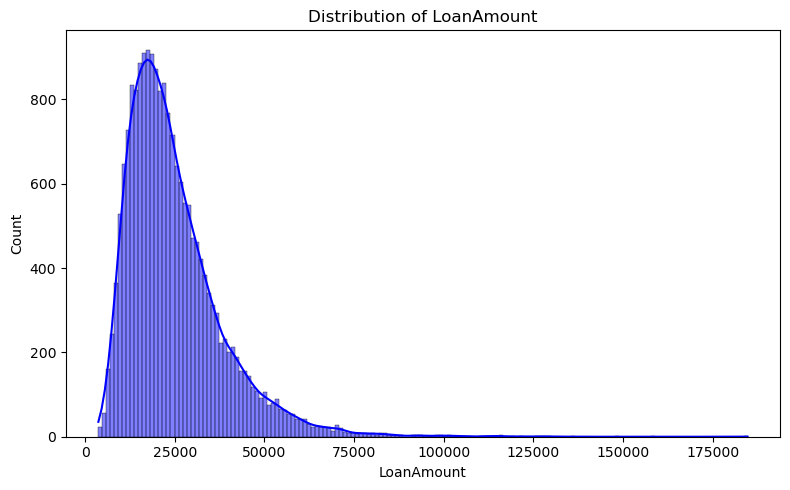

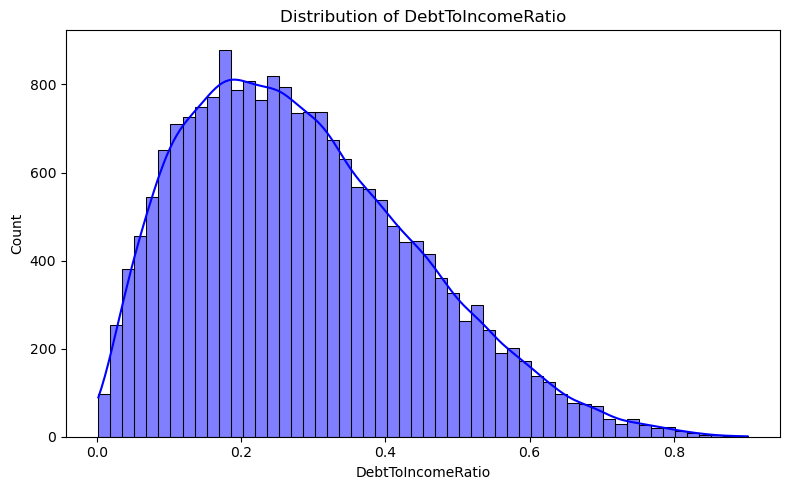

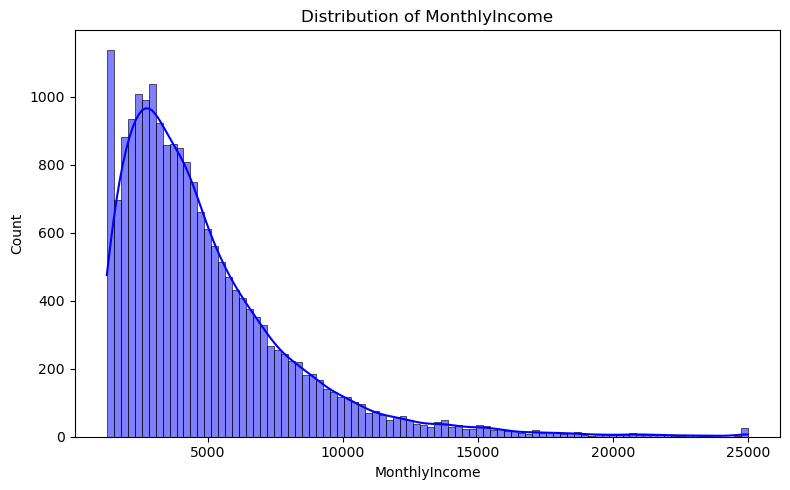

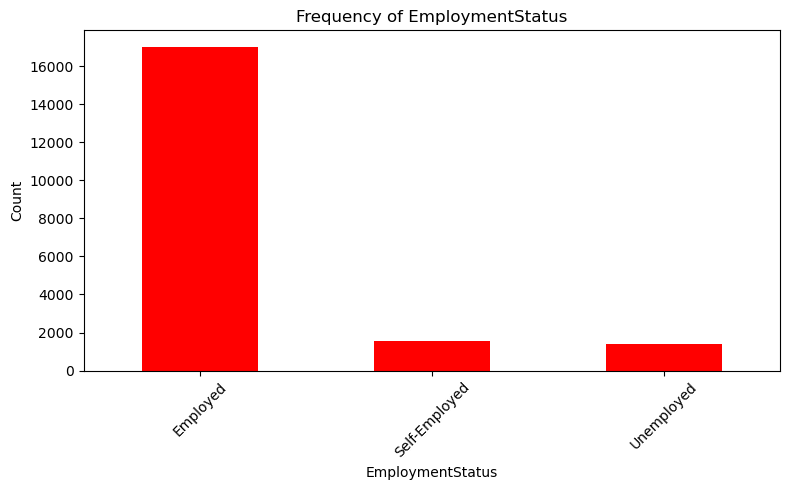

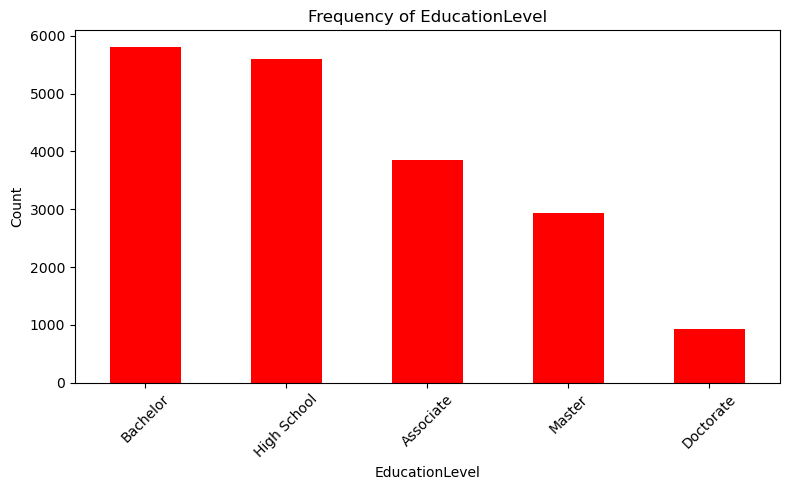

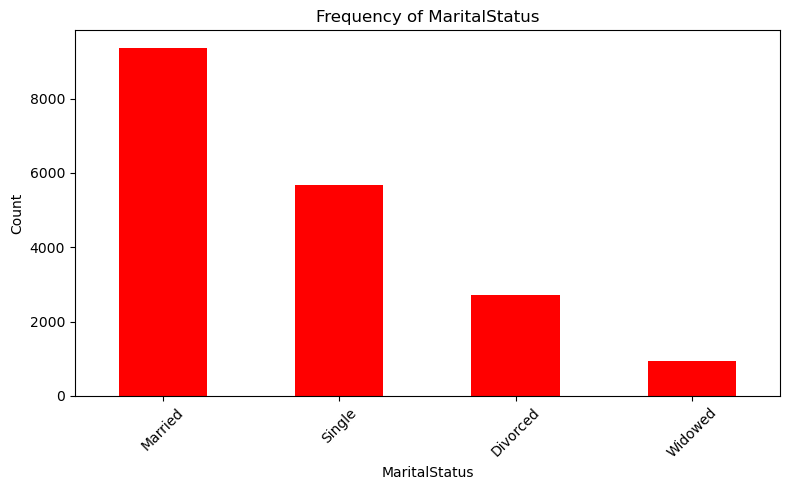

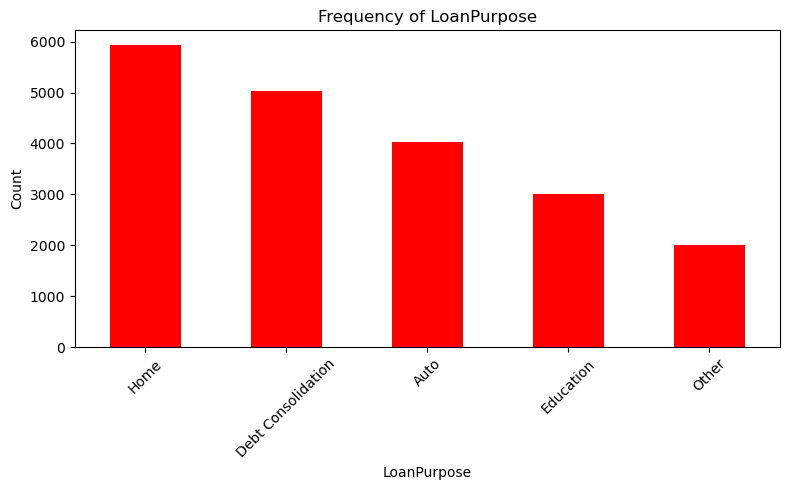

In [19]:
# EDA Code Here - Create New Cells As Needed

# Loading Data set
df = pd.read_csv("financial_loan_data.csv")

# For EDA:
key_numerical = ['CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'MonthlyIncome']
key_categorical = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'LoanPurpose']

# Basic EDA
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df[key_numerical + key_categorical].isnull().sum())
print("\nData Types:")
print(df[key_numerical + key_categorical].dtypes)

# 2. Distribution plots key numericals features
for col in key_numerical:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col].dropna(), kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# 3. Count plots for categorical features
for col in key_categorical:
    plt.figure(figsize=(8, 5))
    df[col].value_counts().plot(kind='bar', color='red')
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Data Preparation
5. Design your preprocessing strategy:
- Create separate preprocessing flows for different feature types
- Must utilize ColumnTransformer and Pipeline
- Consider using FeatureUnion as well
- Handle missing values appropriately for each feature
- Handle Categorical and Ordinal data appropriately
- Scale numeric values if model requires it (linear model)
- Document your reasoning for each preprocessing decision



In [20]:
# Data Prep Code Here - Create New Cells As Needed

numerical_features = ['CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'MonthlyIncome']
categorical_features = ['EmploymentStatus', 'MaritalStatus', 'LoanPurpose']
ordinal_features = ['EducationLevel'] 

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

education_order = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=education_order))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_features)
])

Reasoning:
-Using 'median' fornumerical features to minimize effect of outliers
-For categorical features I use OneHotEncoder to convert everything to standardized and consistent categories.
-Using OrdinalEncoder for Education level because it fits the progression of education
-Used ColumnTransformer to convert all features to be pipeline compatible.

## Modeling
6. Implement your modeling approach:
- Choose appropriate model algorithms based on your problem definition
- Set up validation strategy with chosen metrics
- Use a train test split and cross validation
- Create complete pipeline including any preprocessing and model
- Document your reasoning for each modeling decision

7. Optimize your model:
- Define parameter grid based on your understanding of the algorithms
- Implement GridSearchCV and/or RandomizedSearchCV with chosen metrics
- Consider tuning preprocessing steps
- Track and document the impact of different parameter combinations
- Consider the trade-offs between different model configurations

NOTE: Be mindful of time considerations - showcase “how to tune” 


In [21]:
#  Modeling Code Here - Create New Cells as Needed
# 

X = df.drop(columns=['LoanApproved'])
y = df['LoanApproved']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Attching Model to Preprocessor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Scoring Metrics for Evaluation

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}

rf_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='recall',
    refit=True,
    return_train_score=True
)

rf_grid_search.fit(X_train, y_train)
best_model = rf_grid_search.best_estimator_

# Predicting on the Test Set
y_pred = best_model.predict(X_test)

# Printing Results of Evaluation:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.862
Precision: 0.6723549488054608
Recall: 0.8242677824267782

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.91      3044
           1       0.67      0.82      0.74       956

    accuracy                           0.86      4000
   macro avg       0.81      0.85      0.82      4000
weighted avg       0.88      0.86      0.87      4000



## Evaluation and Conclusion
8. Conduct thorough evaluation of final model:
- Assess models test data performance using your defined metrics
- Analyze performance across different data segments
- Identify potential biases or limitations
- Visualize model performance
    - Classification: Confusion Matrix/ROC-AUC
    - Regression: Scatter Plot (Predicted vs. Actual values)

9. Extract and interpret feature importance/significance:
- Which features had the most impact on your model?
- Does this lead to any potential business recommendations?

10. Prepare your final deliverable:
- Technical notebook with complete analysis
- Executive summary for business stakeholders
- Recommendations for implementation
- Documentation of potential improvements

In [22]:
# Evaluation and Conclusion

final_model = best_model

# 1. final predictions
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# 2. Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.91      3044
           1       0.67      0.82      0.74       956

    accuracy                           0.86      4000
   macro avg       0.81      0.85      0.82      4000
weighted avg       0.88      0.86      0.87      4000

ROC-AUC Score: 0.9270555561664622


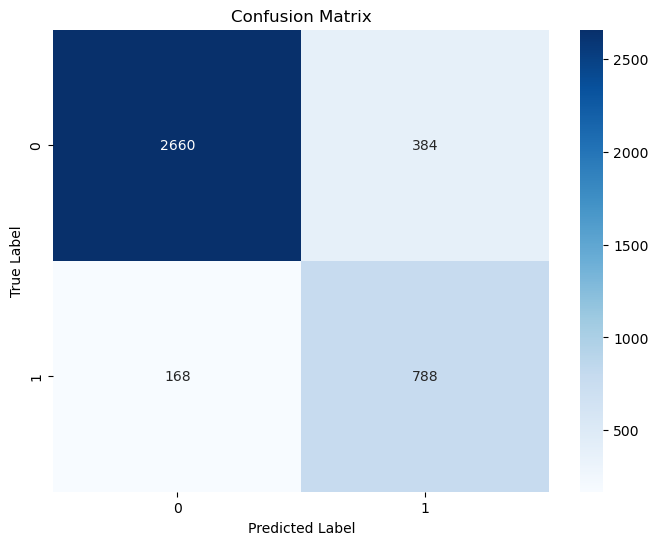

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

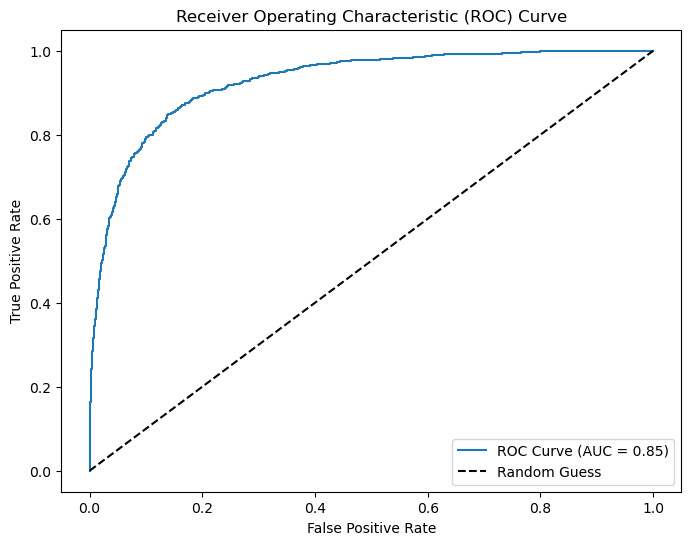

In [28]:
# ROC Curve
roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

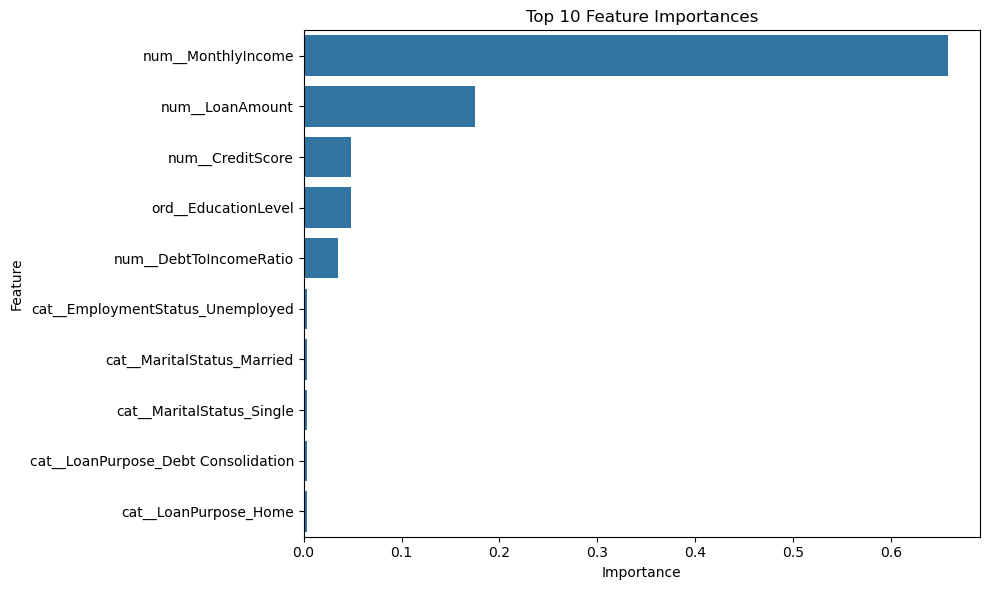

In [31]:
# 5. Feature Importance (XGBoost)
importances = final_model.named_steps['classifier'].feature_importances_
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

In [30]:
### I have run out of time to proceed further with this lab